# Least Square Plate Reduction

The goal of least square plate reduction is to identify a set of linear coefficients that allow for the conversion from pixel values on a CCD image to right ascension and declination values. The equations are calibrated using a field of reference stars, interpolating for the object of interest. The linear transform takes into account translation, scaling, and rotation of the coordinate systems, but does not take into account skew, “barrel,” “pin-cushion,” or other higher-order transforms.

### Import modules

In [16]:
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt

### Read in .csv file

In [17]:
file_path = "./data/refstars-07_18_16.csv"
stars = np.genfromtxt(file_path, delimiter=",", skip_header=1)

asteroid_x = 1387.733
asteroid_y = 1436.548

### Visualize star field

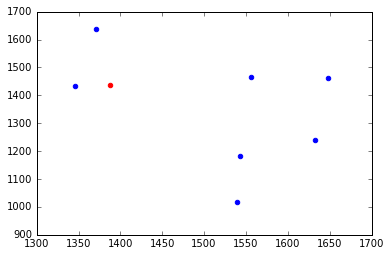

In [18]:
plt.scatter(stars[:, 3], stars[:, 4], color='blue')
plt.scatter(asteroid_x, asteroid_y, color='red')
plt.show()

### Find linear coefficients

In [19]:
def find_coefficients(reference_star_data_file):
    
    data = reference_star_data_file

    ra = data[:, 1]
    dec = data[:, 2] 
    cent_x = data[:, 3]
    cent_y = data[:, 4]
    
    # Matrices derived by setting partial derivatives of
    # chi square equations equal to zero 
    important_matrix = np.matrix([
        [len(ra), sum(cent_x), sum(cent_y)],
        [sum(cent_x), sum(cent_x ** 2), sum(cent_x * cent_y)],
        [sum(cent_y), sum(cent_x * cent_y), sum(cent_y ** 2)]])

    ra_matrix = np.matrix([
        [sum(ra)],
        [sum(ra * cent_x)],
        [sum(ra * cent_y)]])

    dec_matrix = np.matrix([
        [sum(dec)],
        [sum(dec * cent_x)],
        [sum(dec * cent_y)]])
    
    # Solve for coefficient matrices
    ra_coefficients = np.linalg.solve(important_matrix, ra_matrix)
    dec_coefficients = np.linalg.solve(important_matrix, dec_matrix)
    
    a11 = ra_coefficients[1, 0]
    a21 = dec_coefficients[1, 0]
    a12 = ra_coefficients[2, 0]
    a22 = dec_coefficients[2, 0]

    b1 = ra_coefficients[0, 0]
    b2 = dec_coefficients[0, 0]
    
    return (a11, a21, a12, a22, b1, b2)

In [20]:
a11, a21, a12, a22, b1, b2 = find_coefficients(stars)

### Find star field residuals

In [25]:
def find_residuals(reference_star_data_file, a11, a21, a12, a22, b1, b2):
    data = reference_star_data_file

    ra = data[:, 1]
    dec = data[:, 2] 
    cent_x = data[:, 3]
    cent_y = data[:, 4]
    
    index = 0
    for star in data:
        ra_residual = ra[index] - (b1 + a11 * cent_x[index] + a12 * cent_y[index])
        dec_residual = dec[index] - (b2 + a21 * cent_x[index] + a22 * cent_y[index])
        print "Star # %s\tRA -> %s\tDec -> %s" % (index + 1, ra_residual, dec_residual)
        index += 1

In [26]:
find_residuals(stars, a11, a21, a12, a22, b1, b2)

Star # 1	RA -> -0.0299570979014	Dec -> -0.0384366478866
Star # 2	RA -> -0.0117446614083	Dec -> -0.0180139973306
Star # 3	RA -> -0.00668284339343	Dec -> -0.0078245310484
Star # 4	RA -> 0.00406794413993	Dec -> 0.00710990343868
Star # 5	RA -> 0.00231056957904	Dec -> 0.00183885444582
Star # 6	RA -> 0.0107598719858	Dec -> 0.0140250378475
Star # 7	RA -> 0.0312462169982	Dec -> 0.0413013805336


### Find sigma of right ascension and declination

In [27]:
def find_sigma(reference_star_data_file, a11, a21, a12, a22, b1, b2):
    data = reference_star_data_file

    ra = data[:, 1]
    dec = data[:, 2] 
    cent_x = data[:, 3]
    cent_y = data[:, 4]
    
    ra_sigma = np.sqrt((1 / (len(ra) - 3)) * sum((ra - b1 - a11 * cent_x - a12 * cent_y) ** 2))
    dec_sigma = np.sqrt((1 / (len(ra) - 3)) * sum((dec - b2 - a21 * cent_x - a22 * cent_y) ** 2))
    
    print "Sigma (RA) = %s\tSigma (Dec) = %s" % (ra_sigma, dec_sigma)

In [28]:
find_sigma(stars, a11, a21, a12, a22, b1, b2)

Sigma (RA) = 0.0234201462701	Sigma (Dec) = 0.0309012180986


### Get celestial coordinates of object of interest (asteroid)

In [29]:
def to_celestial_coordinates(ooi_x, ooi_y, a11, a21, a12, a22, b1, b2):
    
    ra = ((b1 + a11 * ooi_x + a12 * ooi_y) * 24) / 360
    dec = b2 + a21 * ooi_x + a22 * ooi_y
    
    return ra, dec

In [30]:
ra, dec = to_celestial_coordinates(asteroid_x, asteroid_y, a11, a21, a12, a22, b1, b2)

print "ASTEROID RA = %s" % ra
print "ASTEROID DEC = %s" % dec

ASTEROID RA = 20.4578835684
ASTEROID DEC = 5.41823454948
